# Data preprocessing

In [106]:
## Import libraries
import os
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# 1. Load the data

In [84]:
data_path = "data/mimic IV/" ## Replace with your own path
patients = pd.read_csv(os.path.join(data_path,'patients.csv.gz'))
admissions = pd.read_csv(os.path.join(data_path,'admissions.csv.gz'))
icustays = pd.read_csv(os.path.join(data_path,'icustays.csv.gz'))
diagnoses = pd.read_csv(os.path.join(data_path,'diagnoses_icd.csv.gz'))
procedures = pd.read_csv(os.path.join(data_path,'procedures_icd.csv.gz'))

In [85]:
# Convert key columns to datetime objects ---
# This is crucial for temporal calculations
patients['dod'] = pd.to_datetime(patients['dod']) ##date of death
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

In [86]:
# Get Patient Demographics (Age)
# We merge admissions and patients to get age at admission
admissions = admissions.merge(patients[['subject_id', 'anchor_age', 'anchor_year', 'dod']], on='subject_id')
admissions['age_at_admission'] = admissions['anchor_age'] + (pd.to_datetime(admissions['admittime']).dt.year - admissions['anchor_year'])

In [87]:
#take only adult
adult_admissions = admissions[admissions['age_at_admission'] >= 18]

# Merge with icustays
adult_icu = icustays.merge(adult_admissions, on=['subject_id', 'hadm_id'])

# Find the *first* icu stay for each patient
adult_icu = adult_icu.sort_values(by='intime')
first_icu_stays = adult_icu.groupby('subject_id').first().reset_index()

# Exclude patients who died in the hospital
# `deathtime` in the admissions table is the time of in-hospital death
cohort = first_icu_stays[first_icu_stays['deathtime'].isnull()].copy()

cohort["index_date"] = cohort['intime']

In [88]:
cohort

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,marital_status,race,edregtime,edouttime,hospital_expire_flag,anchor_age,anchor_year,dod,age_at_admission,index_date
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,52,2180,2180-09-09,52,2180-07-23 14:00:00
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252,2150-11-02 18:02:00,2150-11-12 13:45:00,...,WIDOWED,WHITE,2150-11-02 11:41:00,2150-11-02 19:37:00,0,86,2150,2152-01-30,86,2150-11-02 19:37:00
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535,2189-06-27 07:38:00,2189-07-03 03:00:00,...,MARRIED,BLACK/AFRICAN AMERICAN,2189-06-27 06:25:00,2189-06-27 08:42:00,0,73,2186,2193-08-26,76,2189-06-27 08:42:00
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032,2157-11-18 22:56:00,2157-11-25 18:00:00,...,MARRIED,WHITE,2157-11-18 17:38:00,2157-11-19 01:24:00,0,55,2157,NaT,55,2157-11-20 19:18:02
4,10001725,25563031,31205490,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2110-04-11 15:52:22,2110-04-12 23:59:56,1.338588,2110-04-11 15:08:00,2110-04-14 15:00:00,...,MARRIED,WHITE,None,None,0,46,2110,NaT,46,2110-04-11 15:52:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65359,19999287,22997012,37692584,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2197-07-26 03:31:06,2197-07-27 16:07:29,1.525266,2197-07-26 03:29:00,2197-07-31 14:00:00,...,SINGLE,BLACK/AFRICAN AMERICAN,2197-07-26 02:51:00,2197-07-26 05:00:00,0,71,2191,2197-09-02,77,2197-07-26 03:31:06
65361,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,DIVORCED,WHITE,None,None,0,41,2146,NaT,43,2148-11-19 14:23:43
65362,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741,2139-10-10 18:06:00,2139-10-16 03:30:00,...,MARRIED,WHITE,2139-10-10 16:44:00,2139-10-10 19:18:00,0,81,2138,NaT,82,2139-10-10 19:18:00
65363,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995,2149-01-08 16:44:00,2149-01-18 17:00:00,...,SINGLE,WHITE,2149-01-08 09:11:00,2149-01-08 18:12:00,0,46,2147,NaT,48,2149-01-08 18:12:00


# Merge with image identifier

In [95]:
image_link = pd.read_csv('data/cxr-record-list.csv.gz')
image_metadata = pd.read_csv('data/mimic-cxr-2.0.0-metadata.csv.gz')
image_metadata['StudyDate'] = pd.to_datetime(image_metadata['StudyDate'], format='%Y%m%d')

# merge image_link with image_metadata to add StudyDate
image = image_link.merge(image_metadata, left_on=['dicom_id', 'subject_id', 'study_id'], right_on=['dicom_id', 'subject_id', 'study_id'], how='inner')
image


,subject_id,study_id,dicom_id,path,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...,CHEST (PA AND LAT),PA,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,CHEST (PA AND LAT),LATERAL,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),lateral,Erect
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,CHEST (PA AND LAT),PA,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...,CHEST (PA AND LAT),LATERAL,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),lateral,Erect
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...,CHEST (PORTABLE AP),AP,2705,2539,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
377105,19999733,57132437,428e2c18-5721d8f3-35a05001-36f3d080-9053b83c,files/p19/p19999733/s57132437/428e2c18-5721d8f...,CHEST (PA AND LAT),PA,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),postero-anterior,Erect
377106,19999733,57132437,58c403aa-35ff8bd9-73e39f54-8dc9cc5d-e0ec3fa9,files/p19/p19999733/s57132437/58c403aa-35ff8bd...,CHEST (PA AND LAT),LATERAL,3056,2544,2152-07-08,224550.171,CHEST (PA AND LAT),lateral,Erect
377107,19999987,55368167,58766883-376a15ce-3b323a28-6af950a0-16b793bd,files/p19/p19999987/s55368167/58766883-376a15c...,CHEST (PORTABLE AP),AP,2544,3056,2145-11-04,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
377108,19999987,58621812,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,files/p19/p19999987/s58621812/7ba273af-3d290f8...,CHEST (PORTABLE AP),AP,3056,2544,2145-11-02,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


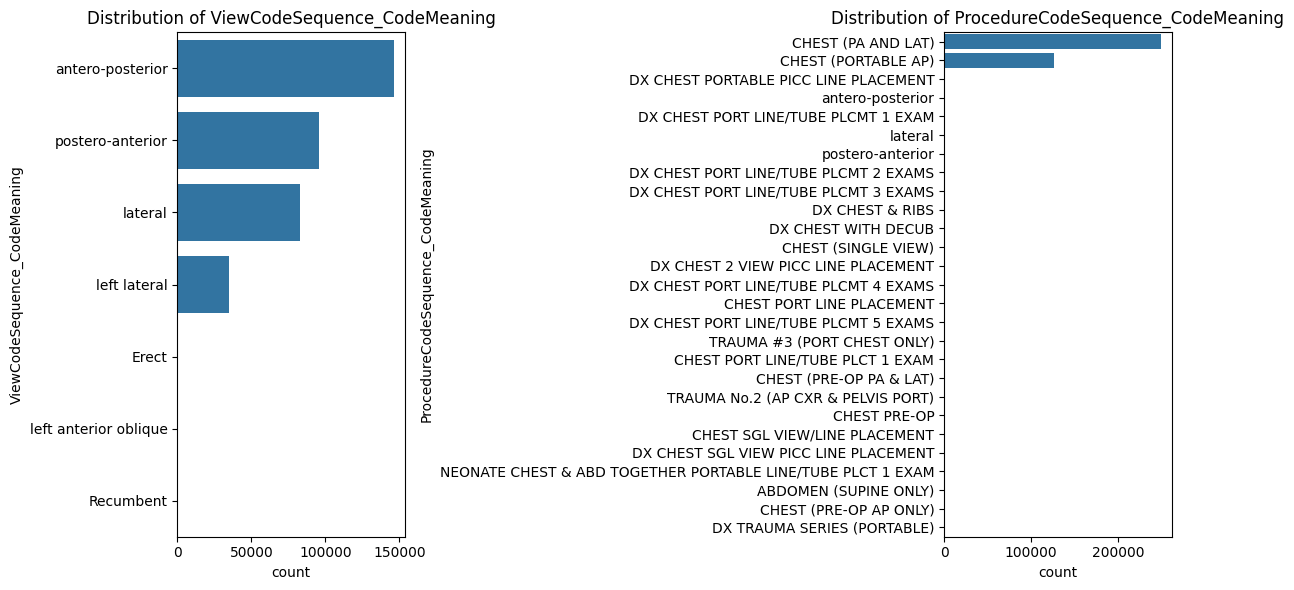

In [96]:
# plot distribution of 'ViewCodeSequence_CodeMeaning' and 'ProcedureCodeSequence_CodeMeaning'
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.countplot(y='ViewCodeSequence_CodeMeaning', data=image, order=image['ViewCodeSequence_CodeMeaning'].value_counts().index)
plt.title('Distribution of ViewCodeSequence_CodeMeaning')
plt.subplot(1,2,2)
sns.countplot(y='ProcedureCodeSequence_CodeMeaning', data=image, order=image['ProcedureCodeSequence_CodeMeaning'].value_counts().index)
plt.title('Distribution of ProcedureCodeSequence_CodeMeaning')
plt.tight_layout()  
plt.show()

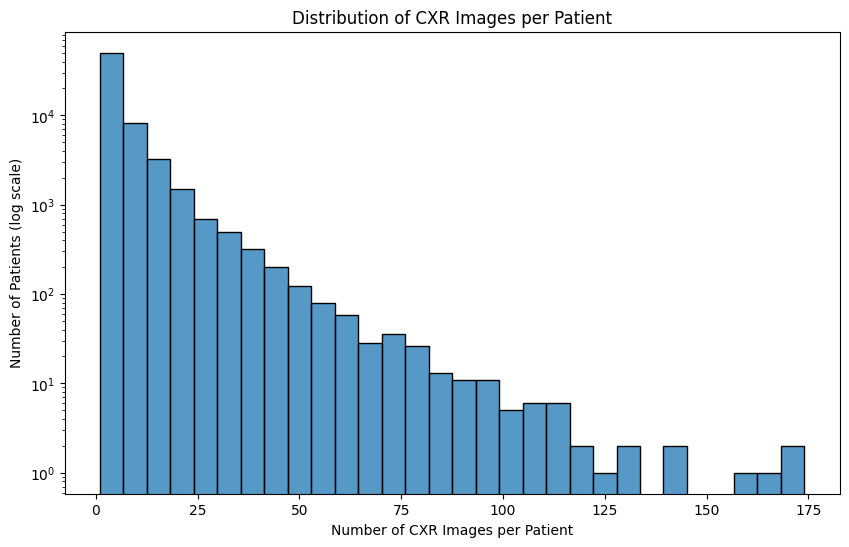

In [97]:
# distribution of number of CXR images per patient
image_counts = image['subject_id'].value_counts()
plt.figure(figsize=(10,6))
sns.histplot(image_counts, bins=30, kde=False)
plt.yscale('log')
plt.xlabel('Number of CXR Images per Patient')
plt.ylabel('Number of Patients (log scale)')
plt.title('Distribution of CXR Images per Patient')
plt.show()

# Merge patients with their dicom files

In [98]:
# merge image_link with patients
cohort = cohort.merge(image, on='subject_id', how='inner')
cohort

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,path,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s50414267/02aa804e-bde0afd...,CHEST (PA AND LAT),PA,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),postero-anterior,Erect
1,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s50414267/174413ec-4ec4c1f...,CHEST (PA AND LAT),LATERAL,3056,2544,2180-05-06,213014.531,CHEST (PA AND LAT),lateral,Erect
2,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s53189527/2a2277a9-b0ded15...,CHEST (PA AND LAT),PA,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),postero-anterior,Erect
3,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s53189527/e084de3b-be89b11...,CHEST (PA AND LAT),LATERAL,3056,2544,2180-06-26,165500.312,CHEST (PA AND LAT),lateral,Erect
4,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s53911762/68b5c4b1-227d048...,CHEST (PORTABLE AP),AP,2705,2539,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157792,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,files/p19/p19999442/s58497551/ee9155f3-944c056...,CHEST (PORTABLE AP),AP,2544,3056,2148-11-28,133244.093,CHEST (PORTABLE AP),antero-posterior,NaN
157793,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,files/p19/p19999442/s58708861/16b6c70f-6d36bd7...,CHEST (PORTABLE AP),AP,2544,3056,2148-11-19,224703.375,CHEST (PORTABLE AP),antero-posterior,Erect
157794,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,...,files/p19/p19999987/s55368167/58766883-376a15c...,CHEST (PORTABLE AP),AP,2544,3056,2145-11-04,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
157795,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02 22:59:00,2145-11-04 21:29:30,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,...,files/p19/p19999987/s58621812/7ba273af-3d290f8...,CHEST (PORTABLE AP),AP,3056,2544,2145-11-02,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


In [99]:
# only keep images taken during the ICU stay
# 'StudyDate' should be between 'intime' and 'outtime'
cohort['intime'] = pd.to_datetime(cohort['intime'].dt.date)
cohort['outtime'] = pd.to_datetime(cohort['outtime'].dt.date)
cohort = cohort[(cohort['StudyDate'] >= cohort['intime']) & (cohort['StudyDate'] <= cohort['outtime'])]
cohort['path'] = cohort['path'].str.replace('.dcm', '.tfrecord')
cohort

/var/folders/bc/220rhkcd2wl94b7fjf0_hg7m0000gn/T/ipykernel_40833/928679615.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort['path'] = cohort['path'].str.replace('.dcm', '.tfrecord')


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,path,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning
4,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23,2180-07-23,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s53911762/68b5c4b1-227d048...,CHEST (PORTABLE AP),AP,2705,2539,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN
5,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23,2180-07-23,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,files/p10/p10000032/s53911762/fffabebf-74fd3a1...,CHEST (PORTABLE AP),AP,2906,2258,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect
9,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27,2189-06-27,0.497535,2189-06-27 07:38:00,2189-07-03 03:00:00,...,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,CHEST (PORTABLE AP),AP,3056,2544,2189-06-27,64348.484,CHEST (PORTABLE AP),antero-posterior,Erect
41,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12,2156-04-17,4.981134,2156-04-12 14:16:00,2156-04-29 16:26:00,...,files/p10/p10002428/s50027225/e8c44648-ff02bee...,CHEST (PORTABLE AP),AP,3056,2544,2156-04-16,30029.015,CHEST (PORTABLE AP),antero-posterior,NaN
49,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12,2156-04-17,4.981134,2156-04-12 14:16:00,2156-04-29 16:26:00,...,files/p10/p10002428/s55758034/3bea0373-0d10dd7...,CHEST (PORTABLE AP),AP,3056,2544,2156-04-15,13210.359,CHEST (PORTABLE AP),antero-posterior,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157785,19999287,22997012,37692584,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2197-07-26,2197-07-27,1.525266,2197-07-26 03:29:00,2197-07-31 14:00:00,...,files/p19/p19999287/s51885769/50373d1b-8df0d15...,CHEST (PORTABLE AP),AP,3056,2544,2197-07-26,25712.640,CHEST (PORTABLE AP),antero-posterior,Erect
157793,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19,2148-11-26,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,files/p19/p19999442/s58708861/16b6c70f-6d36bd7...,CHEST (PORTABLE AP),AP,2544,3056,2148-11-19,224703.375,CHEST (PORTABLE AP),antero-posterior,Erect
157794,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02,2145-11-04,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,...,files/p19/p19999987/s55368167/58766883-376a15c...,CHEST (PORTABLE AP),AP,2544,3056,2145-11-04,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect
157795,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02,2145-11-04,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,...,files/p19/p19999987/s58621812/7ba273af-3d290f8...,CHEST (PORTABLE AP),AP,3056,2544,2145-11-02,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect


In [100]:
# how many unique patients are left?
print(f"Number of unique patients in cohort after merging with CXR images: {cohort['subject_id'].nunique()}")

Number of unique patients in cohort after merging with CXR images: 9891


# Load the embeddings

In [101]:
import tensorflow as tf

In [104]:
embedding_root = '/Users/julian/Downloads/generalized-image-embeddings-for-the-mimic-chest-x-ray-dataset-1.0'

In [105]:
embedding_files = cohort['path'].apply(lambda x: os.path.join(embedding_root, x)).tolist()
existing_files = [p for p in embedding_files if os.path.exists(p)]
missing_count = len(embedding_files) - len(existing_files)
print(f"TFRecord files: found {len(existing_files)}, skipped {missing_count} missing")

TFRecord files: found 35195, skipped 2033 missing


In [107]:
embedding_files = existing_files

def parse_example(serialized):
    features = {
        "image/id": tf.io.FixedLenFeature([], tf.string),
        "embedding": tf.io.VarLenFeature(tf.float32),
    }
    parsed = tf.io.parse_single_example(serialized, features)
    image_id = parsed["image/id"]
    embedding = tf.sparse.to_dense(parsed["embedding"])
    return image_id, embedding

# Dataset pipeline: parallel map, batch and prefetch for efficiency
batch_size = 1024
ds = tf.data.TFRecordDataset(embedding_files)
ds = ds.map(parse_example, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(batch_size)
ds = ds.prefetch(tf.data.AUTOTUNE)

image_ids = []
embeddings = []

for batch_image_id, batch_embedding in ds:
    # convert to numpy; bytes -> str
    img_ids = batch_image_id.numpy().astype("U")  # convert bytes to str
    emb_np = batch_embedding.numpy()              # shape (B, emb_dim)
    image_ids.extend(img_ids.tolist())
    # store embeddings as lists (or keep as np arrays)
    embeddings.extend([e for e in emb_np])

# build DataFrame
df_embeddings = pd.DataFrame({"dicom_id": image_ids, "embedding": embeddings})

# Optional: expand embedding into separate numeric columns if needed
if len(df_embeddings) > 0:
    emb_dim = len(df_embeddings["embedding"].iloc[0])
    # if embedding dim is reasonable, expand
    if emb_dim > 0 and emb_dim <= 1024:  # adjust threshold as desired
        emb_arr = np.vstack(df_embeddings["embedding"].values)
        emb_cols = [f"emb_{i}" for i in range(emb_dim)]
        df_expanded = pd.concat([df_embeddings[["dicom_id"]].reset_index(drop=True),
                                 pd.DataFrame(emb_arr, columns=emb_cols)], axis=1)
    else:
        df_expanded = df_embeddings  # keep as is for very large dims

# make dicom_id the file name without extension
df_expanded['dicom_id'] = df_expanded['dicom_id'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

In [108]:
df_embeddings

,dicom_id,embedding
0,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,"[-0.4663002, -1.1729188, 0.11404295, -1.868590..."
1,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,"[-0.50707304, -1.5622804, 0.37747228, -1.54174..."
2,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,"[0.2519467, -1.2917526, 1.0152953, -2.1014183,..."
3,e8c44648-ff02beea-3d5ff638-dec79b01-7df71a69,"[-1.0334531, -0.75865674, 0.6928189, -2.007725..."
4,3bea0373-0d10dd77-1cac5b90-651be924-d343b184,"[-0.86418974, -0.6880932, 0.4602465, -1.915323..."
...,...,...
35190,50373d1b-8df0d15f-5d0047f4-578bc509-4f2b48f0,"[-0.5933177, -1.1098459, 0.8882481, -2.1478128..."
35191,16b6c70f-6d36bd77-89d2fef4-9c4b8b0a-79c69135,"[-0.046221904, -1.9575974, 0.65582377, -1.8325..."
35192,58766883-376a15ce-3b323a28-6af950a0-16b793bd,"[0.5930662, -1.9391551, 0.6481414, -2.3803892,..."
35193,7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08,"[-0.03341227, -1.678429, 0.76011676, -2.032235..."


In [ ]:
# merge dataframes df_embeddings with image_link
cohort_merged = cohort.merge(df_embeddings, on='dicom_id', how='inner')

In [ ]:
cohort_merged.to_csv('data_processed/cohort_embeddings.csv', index=False)
#cohort_merged_lastscan.to_csv('data_processed/cohort_embeddings_lastscan.csv', index=False)

In [134]:
cohort_merged

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,embedding,time_to_death,death_category
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23,2180-07-23,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,2705,2539,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,NaN,"[-0.4663002, -1.1729188, 0.11404295, -1.868590...",48,48 days
1,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23,2180-07-23,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,2906,2258,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.50707304, -1.5622804, 0.37747228, -1.54174...",48,48 days
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27,2189-06-27,0.497535,2189-06-27 07:38:00,2189-07-03 03:00:00,...,3056,2544,2189-06-27,64348.484,CHEST (PORTABLE AP),antero-posterior,Erect,"[0.2519467, -1.2917526, 1.0152953, -2.1014183,...",1521,1521 days
3,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12,2156-04-17,4.981134,2156-04-12 14:16:00,2156-04-29 16:26:00,...,3056,2544,2156-04-16,30029.015,CHEST (PORTABLE AP),antero-posterior,NaN,"[-1.0334531, -0.75865674, 0.6928189, -2.007725...",-1,Censored (No Death)
4,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12,2156-04-17,4.981134,2156-04-12 14:16:00,2156-04-29 16:26:00,...,3056,2544,2156-04-15,13210.359,CHEST (PORTABLE AP),antero-posterior,NaN,"[-0.86418974, -0.6880932, 0.4602465, -1.915323...",-1,Censored (No Death)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35190,19999287,22997012,37692584,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2197-07-26,2197-07-27,1.525266,2197-07-26 03:29:00,2197-07-31 14:00:00,...,3056,2544,2197-07-26,25712.640,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.5933177, -1.1098459, 0.8882481, -2.1478128...",38,38 days
35191,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19,2148-11-26,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,2544,3056,2148-11-19,224703.375,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.046221904, -1.9575974, 0.65582377, -1.8325...",-1,Censored (No Death)
35192,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02,2145-11-04,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,...,2544,3056,2145-11-04,51448.218,CHEST (PORTABLE AP),antero-posterior,Erect,"[0.5930662, -1.9391551, 0.6481414, -2.3803892,...",-1,Censored (No Death)
35193,19999987,23865745,36195440,Trauma SICU (TSICU),Trauma SICU (TSICU),2145-11-02,2145-11-04,1.937847,2145-11-02 21:38:00,2145-11-11 12:57:00,...,3056,2544,2145-11-02,202809.234,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.03341227, -1.678429, 0.76011676, -2.032235...",-1,Censored (No Death)


In [126]:
cohort_merged_lastscan = cohort_merged.sort_values(by=['subject_id', 'StudyDate']).groupby('subject_id').last().reset_index()

# 2. Make a PCA of the embeddings

<div style="background-color: #f5f1f6; padding: 10px;">

We want to inspect if CXR scans cluster by some clinical or technical variables.

In [127]:
# make a numpy array from the embedding column
# embeddings column should be a array
emb_array = np.vstack(cohort_merged_lastscan['embedding'].values)
print(emb_array.shape)
emb_array

(9758, 1376)


array([[-0.50707304, -1.5622804 ,  0.37747228, ..., -1.4627093 ,
         1.0188926 , -0.43424496],
       [ 0.2519467 , -1.2917526 ,  1.0152953 , ..., -2.1077306 ,
        -0.20285672, -1.4736378 ],
       [-1.0334531 , -0.75865674,  0.6928189 , ..., -2.2332673 ,
         0.23620106, -0.9552237 ],
       ...,
       [-0.5933177 , -1.1098459 ,  0.8882481 , ..., -1.6045979 ,
        -0.05204816, -1.4875659 ],
       [-0.0462219 , -1.9575974 ,  0.65582377, ..., -1.9257301 ,
         0.9880406 , -0.42611787],
       [ 0.5930662 , -1.9391551 ,  0.6481414 , ..., -1.0502896 ,
        -0.48815688, -1.756902  ]], dtype=float32)

In [ ]:
# save embedding array as numpy file
#np.save('data_processed/embeddings.npy', emb_array)
np.save('data_processed/embeddings_lastscan.npy', emb_array)

In [128]:
# run a PCA on the embeddings to reduce dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
emb_reduced = pca.fit_transform(emb_array)

# print explained variance ratio
print(f"Explained variance ratio by 2 components: {pca.explained_variance_ratio_}")

Explained variance ratio by 2 components: [0.14741264 0.08918827]


In [118]:
# print columns of cohort
cohort_merged.columns

Index(['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit',
       'intime', 'outtime', 'los', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'anchor_age',
       'anchor_year', 'dod', 'age_at_admission', 'index_date', 'study_id',
       'dicom_id', 'path', 'PerformedProcedureStepDescription', 'ViewPosition',
       'Rows', 'Columns', 'StudyDate', 'StudyTime',
       'ProcedureCodeSequence_CodeMeaning', 'ViewCodeSequence_CodeMeaning',
       'PatientOrientationCodeSequence_CodeMeaning', 'embedding'],
      dtype='object')

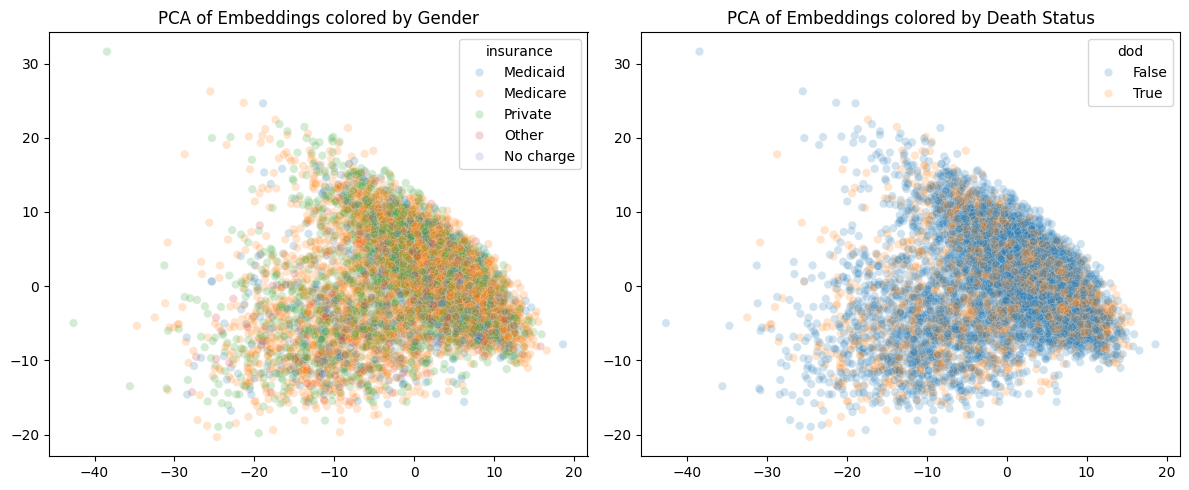

In [129]:
# make two scatter plots, where the first uses gender and the second if dod is not null
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=cohort_merged_lastscan['insurance'], alpha=0.2)
plt.title('PCA of Embeddings colored by Gender')
plt.subplot(1,2,2)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=cohort_merged_lastscan['dod'].notnull(), alpha=0.2)
plt.title('PCA of Embeddings colored by Death Status')
plt.tight_layout()  
plt.show()

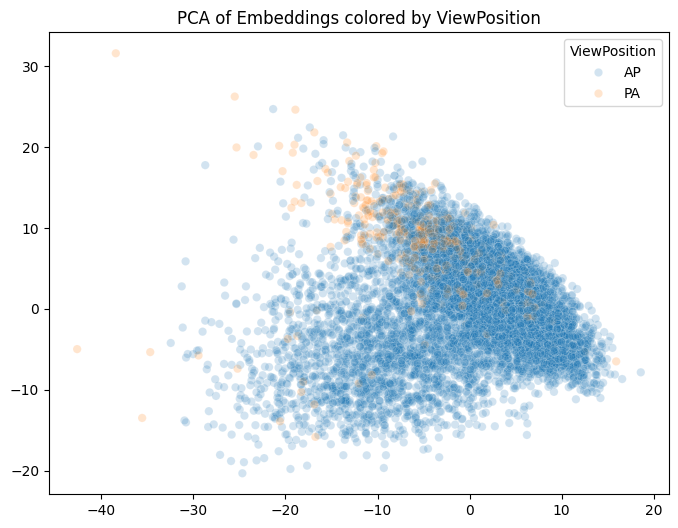

In [130]:
# scatter plot of first two PCA components colored by 'ViewPosition'
plt.figure(figsize=(8,6))
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=cohort_merged_lastscan['ViewPosition'], alpha=0.2)
plt.title('PCA of Embeddings colored by ViewPosition')
plt.show() 

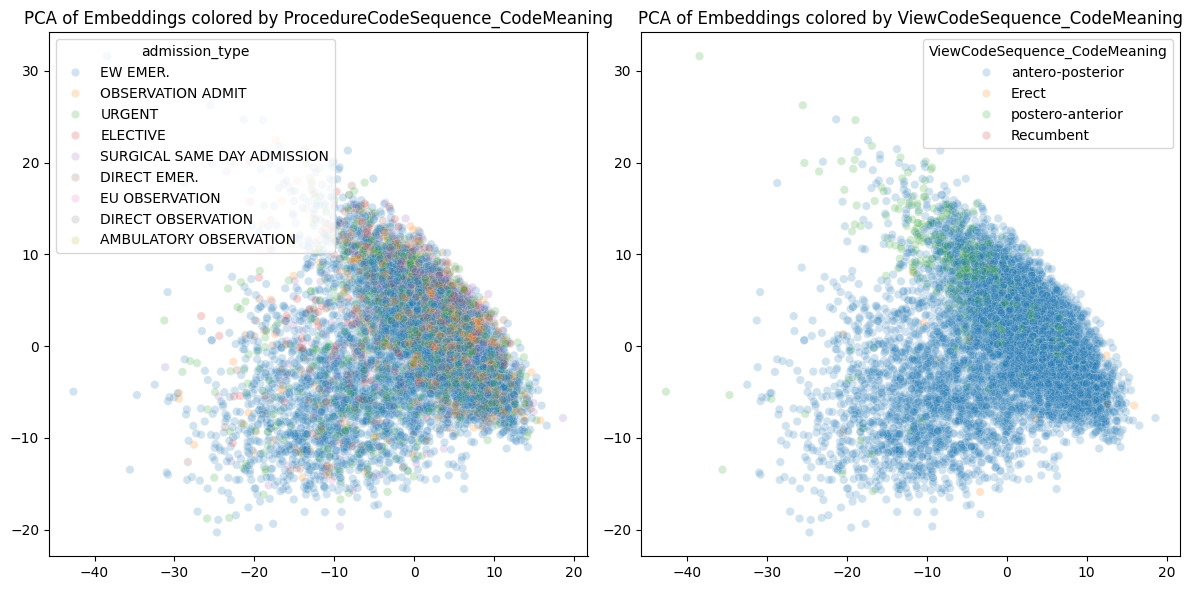

In [131]:
# scatter plot of ProcedureCodeSequence_CodeMeaning	and ViewCodeSequence_CodeMeaning
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=cohort_merged_lastscan['admission_type'], alpha=0.2)
plt.title('PCA of Embeddings colored by ProcedureCodeSequence_CodeMeaning')
plt.subplot(1,2,2)
sns.scatterplot(x=emb_reduced[:,0], y=emb_reduced[:,1], hue=cohort_merged_lastscan['ViewCodeSequence_CodeMeaning'], alpha=0.2)
plt.title('PCA of Embeddings colored by ViewCodeSequence_CodeMeaning')
plt.tight_layout()  
plt.show()

In [132]:
# if dod (date of death) substract study date from dod
# make the difference in days its date object
cohort_merged_lastscan['dod'] = pd.to_datetime(cohort_merged_lastscan['dod'])
cohort_merged_lastscan['StudyDate'] = pd.to_datetime(cohort_merged_lastscan['StudyDate'])
cohort_merged_lastscan['time_to_death'] = cohort_merged_lastscan.apply(lambda row: (row['dod'] - row['StudyDate']).days if pd.notnull(row['dod']) else -1, axis=1)
cohort_merged_lastscan

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,admittime,dischtime,...,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,embedding,time_to_death,death_category
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23,2180-07-23,0.410266,2180-07-23 12:35:00,2180-07-25 17:55:00,...,2906,2258,2180-07-23,80556.875,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.50707304, -1.5622804, 0.37747228, -1.54174...",48,48 days
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27,2189-06-27,0.497535,2189-06-27 07:38:00,2189-07-03 03:00:00,...,3056,2544,2189-06-27,64348.484,CHEST (PORTABLE AP),antero-posterior,Erect,"[0.2519467, -1.2917526, 1.0152953, -2.1014183,...",1521,1521 days
2,10002428,28662225,33987268,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2156-04-12,2156-04-17,4.981134,2156-04-12 14:16:00,2156-04-29 16:26:00,...,3056,2544,2156-04-16,30029.015,CHEST (PORTABLE AP),antero-posterior,Erect,"[-1.0334531, -0.75865674, 0.6928189, -2.007725...",-1,Censored (No Death)
3,10003019,22774359,30676350,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2175-10-08,2175-10-09,0.709213,2175-10-08 13:56:00,2175-10-17 17:30:00,...,3056,2544,2175-10-08,105006.968,postero-anterior,Erect,None,"[0.17203122, -0.8430859, 1.4200679, -2.2508063...",-1,Censored (No Death)
4,10003502,29011269,35796366,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2169-08-26,2169-08-27,1.039456,2169-08-26 16:14:00,2169-08-28 15:20:00,...,2712,2230,2169-08-27,81656.250,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.7301748, -0.95917726, 0.807611, -2.3934374...",14,14 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9753,19998330,23151993,31085771,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2178-09-20,2178-09-21,0.851690,2178-09-20 20:20:00,2178-09-23 18:30:00,...,2768,2544,2178-09-20,180917.656,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.3335524, -0.4049817, 0.64792466, -2.472876...",79,79 days
9754,19998843,24842066,30988867,Trauma SICU (TSICU),Trauma SICU (TSICU),2187-02-05,2187-02-08,3.338646,2187-02-05 09:27:00,2187-02-08 17:28:00,...,2539,2827,2187-02-08,60546.687,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.69910395, -1.545928, 0.87855947, -1.920333...",0,0 days
9755,19999287,22997012,37692584,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2197-07-26,2197-07-27,1.525266,2197-07-26 03:29:00,2197-07-31 14:00:00,...,3056,2544,2197-07-26,25712.640,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.5933177, -1.1098459, 0.8882481, -2.1478128...",38,38 days
9756,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19,2148-11-26,6.950370,2148-11-19 10:00:00,2148-12-04 16:25:00,...,2544,3056,2148-11-19,224703.375,CHEST (PORTABLE AP),antero-posterior,Erect,"[-0.046221904, -1.9575974, 0.65582377, -1.8325...",-1,Censored (No Death)


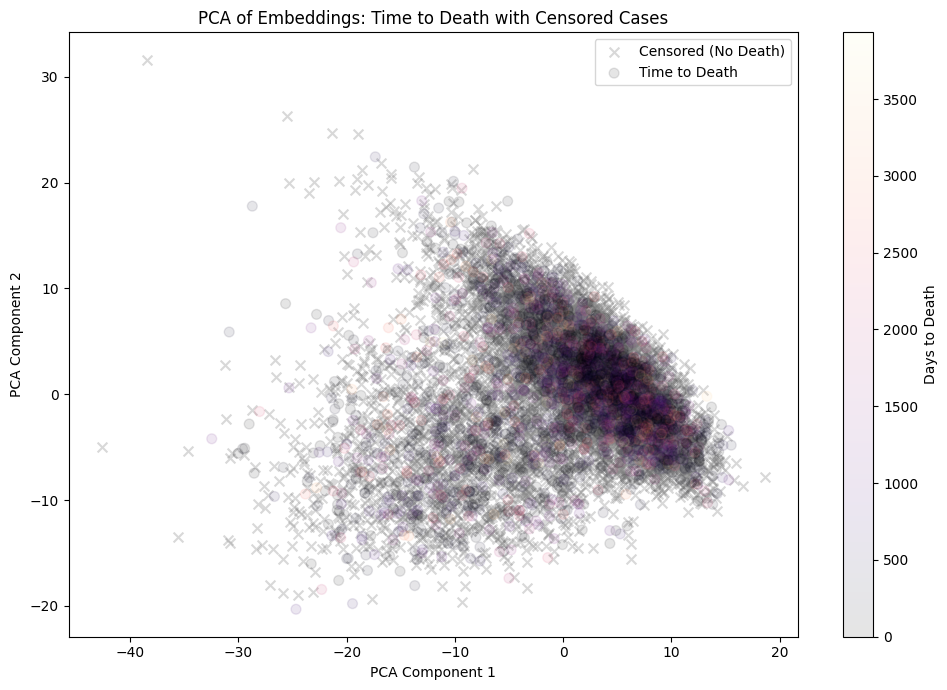

In [133]:
# Create a categorical variable for plotting
cohort_merged_lastscan['death_category'] = cohort_merged_lastscan['time_to_death'].apply(
    lambda x: 'Censored (No Death)' if x == -1 else f'{x} days'
)

# For a better visualization, you might want to bin the continuous values
# Option 1: Keep continuous for non-censored cases
fig, ax = plt.subplots(figsize=(10, 7))

# Plot censored patients separately
censored_mask = cohort_merged_lastscan['time_to_death'] == -1
ax.scatter(emb_reduced[censored_mask, 0], emb_reduced[censored_mask, 1], 
           label='Censored (No Death)', alpha=0.3, s=50, color='gray', marker='x')

# Plot deceased patients with continuous color scale
deceased_mask = ~censored_mask
scatter = ax.scatter(emb_reduced[deceased_mask, 0], emb_reduced[deceased_mask, 1],
                     c=cohort_merged_lastscan.loc[deceased_mask, 'time_to_death'],
                     cmap='magma', alpha=0.1, s=50, label='Time to Death')

plt.colorbar(scatter, label='Days to Death')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Embeddings: Time to Death with Censored Cases')
plt.legend()
plt.tight_layout()
plt.show()